## Physics-Informed Neural Network
인공신경망을 통해 미분방정식의 해 찾기   
미분방정식에서 sample된 data 없이 미분방정식을 만족하는지 여부 (Physical Loss), 경계조건 만족 여부 (Data Loss)를 오차로 사용

#### Simple Harmonic Oscillator
1차원 단순조화진동 $\frac{d^2 f}{dt^2}+\omega^2 f = 0$에 대해 적용

In [14]:
import torch
from torch import nn
from torch import optim

In [15]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1,100)
        self.fc2 = nn.Linear(100,50)
        self.fc3 = nn.Linear(50,20)
        self.fc4 = nn.Linear(20,1)
        self.tanh = nn.Tanh()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.tanh(x)
        x = self.fc2(x)
        x = self.tanh(x)
        x = self.fc3(x)
        x = self.tanh(x)
        x = self.fc4(x)
        return x

In [16]:
def ploss(model, ode, t):
    f = model(t)
    df = torch.autograd.grad(f, t, grad_outputs=torch.ones_like(f), create_graph=True)[0]
    d2f = torch.autograd.grad(df, t, grad_outputs=torch.ones_like(df), create_graph=True)[0]
    return torch.mean(ode(f,df,d2f)**2)

In [17]:
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [18]:
data_points = torch.linspace(0,2,100).reshape(-1,1)
pde_points = torch.linspace(0,4,1000,requires_grad=True).reshape(-1,1)

In [19]:
for epoch in range(1,5001):
    optimizer.zero_grad()
    pde_loss = ploss(model,lambda f,df,d2f:d2f+16*f, pde_points)
    pred = model(data_points)
    data_loss = nn.MSELoss()(pred, torch.cos(4*data_points))

    loss = pde_loss*5*1e-3 + data_loss
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 1000, Loss: 0.03836897015571594
Epoch 2000, Loss: 0.023279521614313126
Epoch 3000, Loss: 0.012307679280638695
Epoch 4000, Loss: 0.008438460528850555
Epoch 5000, Loss: 0.002270003315061331


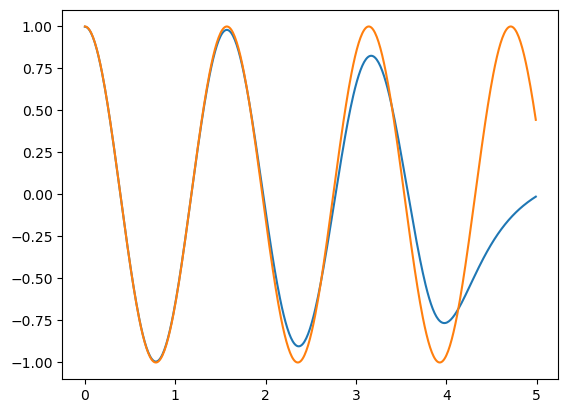

In [21]:
import matplotlib.pyplot as plt
x = torch.tensor([1/100*i for i in range(500)]).reshape(-1,1)
y = model(x).detach()
plt.plot(x,y)
plt.plot(x,torch.cos(4*x))